In [91]:
!conda install fastbook

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - fastbook

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [92]:
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastai.text.all import *
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Mapping, Iterable, Optional
import torchvision.transforms as T
import pickle 

In [93]:
## DATA ##

In [94]:
import zipfile
def extract_data(zipfilename):
    with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
        zip_ref.extractall(".")
# extract_data("50States40Test.zip")
# extract_data("50StatesAll.zip")

In [95]:
root_dir = Path('.')

In [96]:
def prefix(f):
    f = str(f)
    for dir in range(0, 360, 90):
        f = f.rstrip(f"_{dir}.jpg")
    return f

In [100]:
# im_path = root_dir/'50States40Test'
im_path = root_dir/'50StatesAll'
im_files = get_image_files(im_path)

In [101]:
TRAIN_FRAC = 0.9
def splitter(*args, **kwargs):
    random.seed(47)
    train_prefs = set()
    valid_prefs = set()
    train_idx, valid_idx = [], []
    for i, p in enumerate(im_files):
        pref = prefix(p)
        if pref in train_prefs: train_idx.append(i)
        elif pref in valid_prefs: valid_idx.append(i)
        else:
            if random.random() < TRAIN_FRAC:
                train_prefs.add(pref)
                train_idx.append(i)
            else:
                valid_prefs.add(pref)
                valid_idx.append(i)
    return train_idx, valid_idx

In [102]:
# Sanity check the splitter
tri, vli = splitter()
print(len(tri), len(vli))
test = pd.DataFrame({'path': im_files})
test['is_train'] = test.index.isin(tri)
test['state'] = [p.parent.name for p in im_files]
test.groupby(['state', 'is_train']).count().iloc[:50]

449109 50918


path
state         is_train      
Alabama       False      993
              True      9007
Alaska        False     1063
              True      8939
Arizona       False      978
              True      9022
Arkansas      False      975
              True      9027
California    False     1074
              True      8926
Colorado      False      873
              True      9129
Connecticut   False     1046
              True      8954
Delaware      False     1028
              True      8972
Florida       False     1065
              True      8938
Georgia       False      919
              True      9081
Hawaii        False     1112
              True      8891
Idaho         False     1083
              True      8918
Illinois      False     1103
              True      8897
Indiana       False     1067
              True      8933
Iowa          False     1044
              True      8956
Kansas        False     1091
              True      8909
Kentucky      False      963
              True      9037
Louisiana     False     1097
              True      8903
Maine         False     1050
              True      8950
Maryland      False      973
              True      9027
Massachusetts False      936
              True      9064
Michigan      False     1128
              True      8872
Minnesota     False     1156
              True      8844
Mississippi   False     1045
              True      8958
Missouri      False     1029
              True      8971

In [103]:
def get_block_dls(batch_size):
    normalize_tfm = Normalize.from_stats(*imagenet_stats)
    block = DataBlock(
        get_items=get_image_files,
        get_y=parent_label,
        blocks=(ImageBlock, CategoryBlock),
        splitter=splitter,
        batch_tfms=[*aug_transforms(), normalize_tfm],
    )
    dls = block.dataloaders(im_path, batch_size=batch_size)
    return block, dls

In [104]:
# MODEL #

In [105]:
def get_model(arch=resnet101, dropout_amt=0.):
    return nn.Sequential(
        create_body(resnet101, cut=-2),
        create_head(2048, 50, lin_ftrs=[512], ps=dropout_amt),
    )

In [106]:
# TRAIN #

In [107]:
block, dls = get_block_dls(batch_size=64)

In [108]:
model = get_model()

SuggestedLRs(lr_min=0.00017782794311642646, lr_steep=0.0003548133827280253)

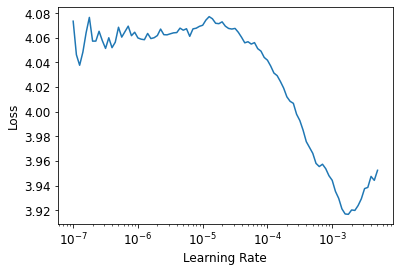

In [111]:
learn = Learner(
    dls=dls, 
    model=model, 
    loss_func=CrossEntropyLossFlat(), 
    metrics=accuracy,
)
learn.freeze()
learn.lr_find(end_lr=1e-2)

In [ ]:
learn.fit_one_cycle(10, )

In [ ]:
torch.save(learn.model.state_dict, root_dir/"state_dict_us_resnet101_frozen_5_30")

In [ ]:
# Are you doing this overnight? If so:
# - Use the normal LR
# - fine-tune for 5 epochs no questions asked

In [ ]:
learn.unfreeze()
learn.lr_find() # If you're there

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4)) # Use better lr if found

In [ ]:
torch.save(learn.model.state_dict, root_dir/"state_dict_us_resnet101_unfrozen_5_30")